# Stochastic gradient descent
Update the parameters based on the gradient for a single training example
$$1. \text{Choose i uniformly}, 2. \theta \leftarrow \theta - \alpha \frac{\partial \mathcal L^{(i)}}{\partial \theta}$$
Therefore, for extremely large dataset, you can see some progress before seeing all the data. 

Such gradient is a biased estimate of the batch gradient
$$E(\partial_\theta L^{(i)}) = N^{-1}\sum_{i=1}^n \partial_\theta L^{(i)} = \partial_\theta J$$
Note that by this expectation, we should do sampling with replacement

### Potential Issues
 - Dependent on the order 
 - Variance can be high, considering some points goes in one direction, while the others goes another
 
## mini-batch
Compute the gradients on a randomly chosen medium-sized set of training example.  

Let $M$ be the size of the mini batch, 
 - $M\uparrow$: computation
 - $M\downarrow$: can't exploit vectorization, high variance

## Learning Rate
The learning rate also influences the __fluctuations__ due to the stochasticity of the gradients.

### Strategy
Start large, gradually decay the learning rate to reduce the fluctuations

By reducing the learning rate, reducing the fluctuations can appear to make the loss drop suddenly, but can come at the expense of long-run performance.

## Non-convex optimization
Have a chance of escaping from local (but non global) minima. If the step-size is too small, it will likely to fall into the local minimum. 

# GD with Momentum
compute an exponentially weighted average of the gradient, and the use the gradient to update the weights

## Algorithm

initialize $V= 0$
$$V\leftarrow \beta V + (1-\beta)\frac{\partial E}{\partial w}$$
$$w \leftarrow w - \alpha V$$
where $\alpha$ is the learning rate, $\beta$ is the momentum. Commonly, $\beta$ is around 0.9

# Demo: (Gradient Based) Optimization for Machine Learning

We will cover how to use the python package **autograd** to solve simple optimization problems. 

Autograd is a lightweight package that automates differentiating through numpy code. Understanding how to use it (and how it works) is not only a useful skill in itself, but also will it help you understand the inner workings of popular deep learning packages such as PyTorch. 

(optional) Check out the github page of autograd: https://github.com/HIPS/autograd. Specifically, check out the "examples" directory, where you can find transparent implementations of many interesting machine learning methods. 

In [1]:
import autograd.numpy as np
import autograd
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)
import time
np.random.seed(1)

This tutorial explores _optimization for machine learning_.

We will implement a function and then use gradient-based optimization to find it's minimum value. 
For ease of visualization we will consider scalar functions of 2-d vectors. 
In other words $f: \mathbb{R}^2 \rightarrow \mathbb{R}$

One example of such a function is the simple quadratic $$f(x) = \frac{1}{2} x^T x = \frac{1}{2}(x_0^2 + x_1^2)$$ where $x_i$ represents the $i$-th entry of the vector $x$.

**Question: is this function convex?**

Let's implement this in code and print $f(x)$ for a few random $x$

In [2]:
def f(x):
    return 0.5*np.dot(x.T, x)

for _ in range(5):  
    x = np.random.randn(2)  # random 2-d vector
    print('x={}, f(x)={:.3f}'.format(x, f(x)))

x=[ 1.624 -0.612], f(x)=1.506
x=[-0.528 -1.073], f(x)=0.715
x=[ 0.865 -2.302], f(x)=3.023
x=[ 1.745 -0.761], f(x)=1.812
x=[ 0.319 -0.249], f(x)=0.082


This simple function has minimum value $f(x^*)=0$ given by $x^* = [0, 0]^T$. 

Let's look at the more general quadratic 
$$f(x) = \frac{1}{2}x^T A x$$
where $A \in \mathbb{R}^{2 \times 2}$ is a positive semi-definite matrix. (Intuitively, these are matrices that "stretch or shrink [eigenvectors] without rotating them. ")

Notice that we get the previous function when we set $A$ to the identity matrix $I$.

We can think of this function as a quadratic bowl whose curvature is specified by the value of $A$.
This is evident in the isocontour plots of $f(x)$ for various $A$.
Let's take a look.


In [3]:
# helper function yielding a random positive semi-definite matrix
def random_psd_matrix(seed=None):
    """return random positive semi-definite matrix with norm one"""
    np.random.seed(seed)
    A = np.random.randn(2,2)
    A = np.dot(A.T,A)
    A = np.dot(A.T,A)
    A = A / np.linalg.norm(A, ord=2)
    return A

# define forward function
def f(x, a):
    """f(x) = x^T A x"""
    y = 0.5*np.dot(x.T, np.dot(a, x))
    return y

# helper function for isocontour plotting
def plot_isocontours(one_d_grid, g):
    """
    first makes a 2d grid from the 1d grid
    then plots isocontours using the function g
    """
    X,Y = np.meshgrid(one_d_grid, one_d_grid)  # build 2d grid
    Z = np.zeros_like(X)
    # numpy bonus exercise: can you think of a way to vectorize the following for-loop?
    for i in range(len(X)):
        for j in range(len(X.T)):
            Z[i, j] = g(np.array((X[i, j], Y[i, j])))  # compute function values
    fig, ax = plt.subplots()
    ax.contour(X, Y, Z, 100)
    return fig, ax 

A=[[1. 1.]
 [1. 1.]]


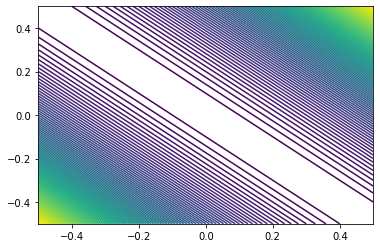

A=[[0.435 0.467]
 [0.467 0.614]]


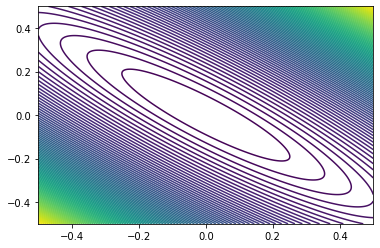

A=[[ 0.942 -0.206]
 [-0.206  0.272]]


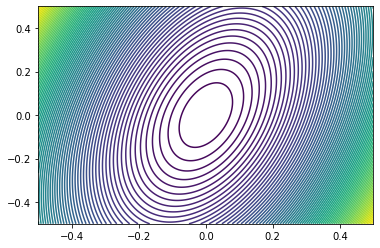

In [4]:
for A in [np.ones((2, 2)), random_psd_matrix(0), random_psd_matrix(1)]:  # try a few values of A
    print('A={}'.format(A))
    fig, ax = plot_isocontours(np.linspace(-0.5, 0.5, 400), lambda x: f(x, A))
    plt.show()
    time.sleep(1.0)

Now let's learn how to find the minimal value of $f(x)$. 
We need to solve the following optimization problem:
$$x^* = \underset{x}{\arg \min} \quad \frac{1}{2}x^T A x = \underset{x}{\arg \min} \quad f(x)$$


Modern machine learning optimization tools rely on gradients. 
Consider gradient descent, which initializes $x_0$ at random then follows the update rule 
$$ x_{t+1} \leftarrow x_t - \eta \nabla_x f(x_t)$$
where $\eta$ represents the learning rate.

So we need to compute $\nabla_x f(x)$. For simple functions like ours, we can compute this analytically:
$$\nabla_x f(x) = \nabla_x \left( \frac{1}{2}x^T A x \right) = A x$$

In other words, to compute the gradient of $f(x)$ at a particular $x=x'$, we matrix multiply $A$ with $x'$

But deriving the analytic gradients by hand becomes painful as $f$ gets more complicated. Instead we can use automatic differentation packages like [`autograd`](https://github.com/HIPS/autograd) to do this hard work for us. All we need to do is specify the forward function.

Let's take a look at the two approaches:

In [5]:
# define df/dx via automatic differentiation
df_dx = autograd.grad(f, 0)
# ^ the second argument of grad specifies which argument we're differentiating with respect to (i.e. x, 
# or A in this case). Note that f(x, A) has 2 arguments: x, A. So does grad{f(x,A)}, also x and A. 

# define df/dx analytically 
def analytic_gradient(x, A):
    return np.dot(A, x)

for A in [np.zeros((2, 2)), np.eye(2), random_psd_matrix()]:  # try a few values of A
    x = np.random.randn(2)  # generate x randomly
    print('')
    print('x={}\nA={}\nf(x,A)={:.3f}\ndf/dx={}'.format(x, A, f(x,A), df_dx(x,A)))
    assert np.isclose(np.sum((df_dx(x, A) - analytic_gradient(x, A)))**2, 0.), 'bad maths'  # unit test
    


x=[-1.35  -1.175]
A=[[0. 0.]
 [0. 0.]]
f(x,A)=0.000
df/dx=[0. 0.]

x=[-0.176 -0.014]
A=[[1. 0.]
 [0. 1.]]
f(x,A)=0.016
df/dx=[-0.176 -0.014]

x=[-0.577 -1.089]
A=[[0.81  0.393]
 [0.393 0.191]]
f(x,A)=0.494
df/dx=[-0.895 -0.434]


Now that we know how to compute $\nabla_x f(x)$ using `autograd`, let's implement gradient descent.

To make the implementation of GD crystal clear, let's break this update expression from above into two lines:
$$ \delta_{t+1} \leftarrow - \eta \nabla_x f(x_t)$$
$$ x_{t+1} \leftarrow x_t + \delta_{t+1}$$

This yields the following `autograd` implementation:

final value f(x)=0.144 at x=[-0.178 -0.547]


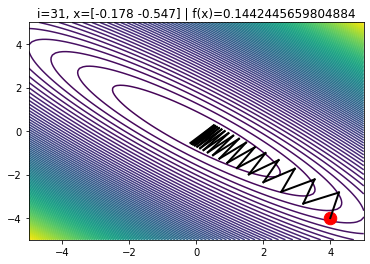

In [6]:
A = random_psd_matrix(0)  # argument specifies the random seed
fig, ax = plot_isocontours(np.linspace(-5, 5, 100), lambda x: f(x, A))  # plot function isocontours

# hyperparameters
LEARNING_RATE = 2.0 
INITIAL_VAL = np.array([4., -4.])  # initialize

x = np.copy(INITIAL_VAL)
ax.plot(*x, marker='.', color='r', ms=25)  # plot initial values



from IPython import display

for i in range(32):
#     input("Press Enter to continue...")  # optional; Enter key triggers next update
#     time.sleep(0.5)  # optional; slow down animation if the flickering is distracting

    x_old = np.copy(x)
    
    delta = -LEARNING_RATE*df_dx(x, A)  # compute gradient times learning rate
    x += delta  # update params
    
    # plot
    # plot a line connecting old and new param values
    ax.plot([x_old[0], x[0]], [x_old[1], x[1]], linestyle='-', color='k',lw=2)  
    fig.canvas.draw()
    ax.set_title('i={}, x={} | f(x)={}'.format(i, x, f(x, A)))
    display.display(fig)
    display.clear_output(wait=True)

print('final value f(x)={:.3f} at x={}'.format(f(x, A), x))


Cool! Now let's try gradient descent _with momentum_. The hyperparameters are the learning rate $\eta$ and momentum value $\alpha \in [0, 1)$.

We randomly initialize $x_0$ like before. We initialize $\delta_0$ to the zero vector. Then proceed with updates as:
$$\delta_{t+1} \leftarrow -\eta \nabla_x f(x) + \alpha \delta_t$$
$$x_{t+1} \leftarrow x_t + \delta_{t+1}$$

This yields the following `autograd` implementation:

final value f(x)=0.000 at x=[-0.  0.]


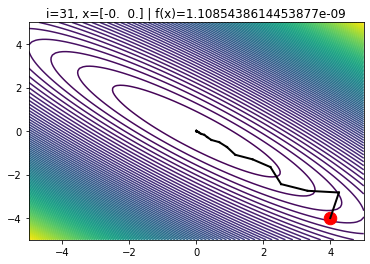

In [7]:
fig, ax = plot_isocontours(np.linspace(-5, 5, 100), lambda x: f(x, A))  # plot function isocontours

# initialize
x = np.copy(INITIAL_VAL)
delta = np.zeros(2) 
ax.plot(*x, marker='.', color='r', ms=25)  # plot initial values

# hyperparameters
LEARNING_RATE = 2.0
ALPHA = 0.5

from IPython import display

for i in range(32):
#    input("Press Enter to continue...")  # optional; Enter key triggers next update
#    time.sleep(0.5)  # optional; slow down animation if the flickering is distracting

    x_old = np.copy(x)
    delta_old = np.copy(delta)
    
    g = df_dx(x, A)  # compute standard gradient
    delta = -LEARNING_RATE*g + ALPHA*delta_old  # update momentum term
    x += delta  # update params
    
    # plot
    ax.plot([x_old[0], x[0]], [x_old[1], x[1]],'-k',lw=2)  # plot a line connecting old and new param values
    fig.canvas.draw()
    ax.set_title('i={}, x={} | f(x)={}'.format(i, x, f(x, A)))
    display.display(fig)
    display.clear_output(wait=True)

print('final value f(x)={:.3f} at x={}'.format(f(x, A), x))


(optional) Distill (https://distill.pub) is an amazing resource to both learn concepts about machine learning, but also a new format for serious scientific discourse. If you are interested in learning more about why momentum is very effective, check this out: https://distill.pub/2017/momentum/ 